In [41]:
import azureml.core

print("Ready to use Azure ML", azureml.core.VERSION)

Ready to use Azure ML 1.53.0


In [42]:
from azureml.core import Workspace
ws = Workspace.from_config()
ws
print(ws.name, "loaded")

mlw-dp100-labs loaded


/Users/timothy/Programming/azure training
starting experiment mslearn-diabetes
Analyzing 10000 rows of data


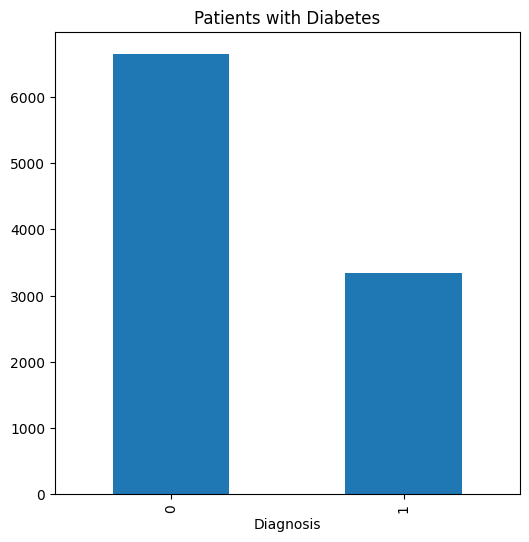

In [43]:
from azureml.core import Experiment
import pandas as pd
import matplotlib.pyplot as plt

import os

#os.chdir("./ml_sdk")

path = os.getcwd()
print(path)


if ws is None:
    raise Exception("Could not load Azure ML workspace from configuration file.")

# This creates a new experiment in my workspace
experiment = Experiment(workspace = ws, name = "mslearn-diabetes")
run = experiment.start_logging(snapshot_directory=None) # argument snapshot_directory set to None as folder was exceeding folder size limit.
print("starting experiment", experiment.name)

# load data
data = pd.read_csv('./diabetes.csv')
row_count = len(data)
run.log('observations', row_count)
print(f'Analyzing {row_count} rows of data')

# Plot
diabetic_counts = data['Diabetic'].value_counts()
fig = plt.figure(figsize=(6,6))
ax = fig.gca()
diabetic_counts.plot.bar(ax=ax)
ax.set_title('Patients with Diabetes')
ax.set_xlabel('Diagnosis')
plt.show()
run.log_image(name='label distribution', plot=fig)

# pregnancies = data.Pregnancies.value_counts()
# pregnancies.plot.bar(ax=ax)
# ax.set_title('Pregnancies')
# plt.show()



In [44]:
pregnancies = data.Pregnancies.unique()
run.log_list('pregnancy categories', pregnancies)
med_columns = ['PlasmaGlucose', 'DiastolicBloodPressure','TricepsThickness', 'SerumInsulin','BMI']

run.clean # to avoid name duplication errors when rerunning. 
for col in med_columns:
    summary_stats = data[col].describe().to_dict()
    for key, value in summary_stats.items():
        run.log_row(col, stat=key, value=value)

data.sample(100).to_csv('sample.csv',index=False, header=True)
run.upload_file(name='outputs/sample.csv', path_or_stream='./sample.csv')

run.complete()

In [45]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [46]:

# Logged metrics
print("Metrics")

metrics = run.get_metrics()
for metric_name in metrics:
    print(metric_name,':',metrics[metric_name])

print('Files')
files = run.get_file_names()
for file in files:
    print(file)

Metrics
observations : 10000
label distribution : aml://artifactId/ExperimentRun/dcid.94d12980-c12a-4b5b-a440-04b52f4629b4/label distribution_1694289502.png
pregnancy categories : [0, 8, 7, 9, 1, 3, 5, 2, 6, 11, 4, 13, 10, 12, 14]
PlasmaGlucose : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 107.8502, 31.92090936056554, 44.0, 84.0, 105.0, 129.0, 192.0]}
DiastolicBloodPressure : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 71.2075, 16.80147828964082, 24.0, 58.0, 72.0, 85.0, 117.0]}
TricepsThickness : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 28.8176, 14.506480415228355, 7.0, 15.0, 31.0, 41.0, 92.0]}
SerumInsulin : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 139.2436, 133.77791937465324, 14.0, 39.0, 85.0, 197.0, 796.0]}
BMI : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0

In [47]:
import os
# downloads all the files from azure to a local file called download_folder
download_folder = 'downloaded-files'

run.download_files('outputs',output_directory = download_folder)

for root, directories, filenames in os.walk(download_folder):
    for filename in filenames:
        print(os.path.join(root, filename))

downloaded-files/outputs/sample.csv


In [48]:
run.get_details_with_logs()

{'runId': '94d12980-c12a-4b5b-a440-04b52f4629b4',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2023-09-09T19:58:22.483235Z',
 'endTimeUtc': '2023-09-09T19:58:25.629746Z',
 'services': {},
 'properties': {},
 'inputDatasets': [],
 'outputDatasets': [],
 'logFiles': {},
 'submittedBy': 'Timothy Perera'}

In [49]:
# Running and experiment script
import os, shutil # shutil gives functions for working with directories and files.

folder_name = 'diabetes-experiment-files'
experiment_folder = './' + folder_name
os.makedirs(folder_name, exist_ok = True) # exist ok = False raises an exception if a file with the same name already exists

#shutil.copy(src, dst): Copies a single file from the src location to the dst location.
shutil.copy('diabetes.csv', os.path.join(folder_name,'diabetes.csv'))


'diabetes-experiment-files/diabetes.csv'

In [50]:
%%writefile $folder_name/diabetes_experiment.py 
# creates a file with the contents of this cell to file

from azureml.core import Run
import pandas as pd
import os

run = Run.get_context()
# For example, when running a script as part of an AzureML experiment,
# this context contains information about the experiment run, such as 
# the run ID, the workspace, and other relevant details. -> ChatGPT explanation
run.clean
data = pd.read_csv('diabetes.csv')

# counting rows and logging result
row_count = len(data)
run.log('Observations:',row_count)
print(f'Analyzing {row_count} rows of data.')

diabetic_counts = data['Diabetic'].value_counts()
print(f'Diabetic Counts:')
for key, value in diabetic_counts.items():
    run.log('Label:' + str(key), str(value))

# Save a sample of data input to the outputs folder
os.makedirs('outputs',exist_ok = True) # create the directory first
data.sample(100).to_csv('outputs/sample.csv',index=False,header=True)

run.complete()


Overwriting diabetes-experiment-files/diabetes_experiment.py


In [52]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.runconfig import DockerConfiguration
from azureml.widgets import RunDetails

# Create a python environment for the experiment 
env = Environment.from_conda_specification('experiment_env','environment.yml')
#The purpose of this step is to ensure that the experiment runs within a controlled 
# and isolated Python environment with the specific dependencies specified in 
# "environment.yml." This helps ensure reproducibility and consistency in the experiment's execution.

# create the script config - this is what executes the experiment
script_config = ScriptRunConfig(source_directory = experiment_folder,
                            script = 'diabetes_experiment.py',
                            environment=env, # this creates an environment within my machine
                            
                            
                            docker_runtime_config=DockerConfiguration(use_docker=True)) 
                            # docker > this creates a isolated environment which considers more factors 
                            # like operating system and system level dependencies
# submit experiment
experiment = Experiment(workspace=ws, name='mslearn-diabetes')
run = experiment.submit(config=script_config)
RunDetails(run).show()
run.wait_for_completion()
                            

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'mslearn-diabetes_1694289514_c6a4495f',
 'target': 'local',
 'status': 'Finalizing',
 'startTimeUtc': '2023-09-09T19:58:46.603399Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': '007e01c9-970e-4eb3-bc78-d176cb9e11c0'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_experiment.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'datacaches': [],
  'jobName': None,
  'maxRunDurationSeconds': 2592000,
  'nodeCount': 1,
  'instanceTypes': [],
  'priority': None,
  'credentialPassthrough': False,
  'identity': None,
  'environment': {'name': 'experiment_env',
   'version': 'Autosave_2023-09-08T18:41:09Z_b9adc945',
   'assetId': 'azureml://locations/canadacentral/workspaces/db2e5a15-d42a-49d7-b494-181af9d9e23d/envi

In [53]:
metrics = run.get_metrics()
for key in metrics.keys():
    print(key, metrics.get(key))
print('\nFiles')
for file in run.get_file_names():
    print(file)

Observations: 10000
Label:0 6656
Label:1 3344

Files
azureml-logs/60_control_log.txt
azureml-logs/70_driver_log.txt
logs/azureml/8_azureml.log
outputs/sample.csv


In [54]:
run.get_details_with_logs()
# gives information like print or log statements, environments, logging etc...Experiment

{'runId': 'mslearn-diabetes_1694289514_c6a4495f',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2023-09-09T19:58:46.603399Z',
 'endTimeUtc': '2023-09-09T19:59:04.406497Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': '007e01c9-970e-4eb3-bc78-d176cb9e11c0'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_experiment.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'datacaches': [],
  'jobName': None,
  'maxRunDurationSeconds': 2592000,
  'nodeCount': 1,
  'instanceTypes': [],
  'priority': None,
  'credentialPassthrough': False,
  'identity': None,
  'environment': {'name': 'experiment_env',
   'version': 'Autosave_2023-09-08T18:41:09Z_b9adc945',
   'assetId': 'azureml://locations/canadacentral/workspa

In [55]:
# Viewing experiment run history
from azureml.core import Experiment, Run
diabetes_experiment = ws.experiments['mslearn-diabetes']
for logged_run in diabetes_experiment.get_runs():
    print('Run ID:', logged_run.id)
    metrics = logged_run.get_metrics()
    for key in metrics.keys():
        print('-', key, metrics.get(key))

Run ID: mslearn-diabetes_1694289514_c6a4495f
- Observations: 10000
- Label:0 6656
- Label:1 3344
Run ID: 94d12980-c12a-4b5b-a440-04b52f4629b4
- observations 10000
- label distribution aml://artifactId/ExperimentRun/dcid.94d12980-c12a-4b5b-a440-04b52f4629b4/label distribution_1694289502.png
- pregnancy categories [0, 8, 7, 9, 1, 3, 5, 2, 6, 11, 4, 13, 10, 12, 14]
- PlasmaGlucose {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 107.8502, 31.92090936056554, 44.0, 84.0, 105.0, 129.0, 192.0]}
- DiastolicBloodPressure {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 71.2075, 16.80147828964082, 24.0, 58.0, 72.0, 85.0, 117.0]}
- TricepsThickness {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 28.8176, 14.506480415228355, 7.0, 15.0, 31.0, 41.0, 92.0]}
- SerumInsulin {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 139.2436, 133.77791937

In [56]:
from azureml.core import Experiment
import pandas as pd
import mlflow
#import mlflow: Import the mlflow library, which is an open-source platform for 
# managing the end-to-end machine learning lifecycle, including experiment tracking.
# it is supposed to complement Azure ML by making it easy to track experiment parameters, metrics, meta data
# associated with the experiment. This is an integration between MLFlow and Azure ML. 

# This method retrieves the tracking URI associated with your Azure Machine Learning workspace. 
# It essentially tells MLflow where it should store and retrieve experiment tracking information.
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

# Create the Azure experiment in my workspace. 
experiment = Experiment(workspace=ws, name='mslearn-diabetes-mlflow')
mlflow.set_experiment(experiment.name) # This points ML flow to our workspace 

with mlflow.start_run():
    print("Starting experiment:", experiment.name)

    # Load data 
    data = pd.read_csv('diabetes.csv')

    # Count rows and log result 
    row_count = len(data)
    mlflow.log_metric('Observations:', row_count)
    print('Run Complete')


Starting experiment: mslearn-diabetes-mlflow
Run Complete


In [59]:
# Retrieving metrics logged during the run
run = list(experiment.get_runs())[0] # get_runs returns a generator object, this method returns an azure run object

# get logged metrics
metrics = run.get_metrics()
for key in metrics.keys():
    print(key, metrics.get(key))

# link to azure ml studio
experiment_url = experiment.get_portal_url()
print('See details at', experiment_url)

Observations: 10000.0
See details at https://ml.azure.com/experiments/id/39f55f06-ddbe-4179-9a3e-16f94a603360?wsid=/subscriptions/a2796f71-1dba-469f-a616-1d5fb0133721/resourcegroups/rg-dp100-labs/workspaces/mlw-dp100-labs&tid=13799db8-a84f-4912-9745-53c85c86e1a9


In [62]:
import os, shutil
# folder for experiments
folder_name = 'mlflow-experiment-files'
experiment_folder = './' + folder_name
os.makedirs(folder_name, exist_ok = True)

shutil.copy('diabetes.csv',os.path.join(folder_name,'diabetes.csv'))

'mlflow-experiment-files/diabetes.csv'

In [70]:
%%writefile $folder_name/mlflow_diabetes.py
# Experiment Script

# In an experiment script, ML Flow automatically sets the tracking URI, but we need to include the mlflow packages (next cell)
from azureml.core import Run 
import pandas as pd
import mlflow

with mlflow.start_run():
    data = pd.read_csv('diabetes.csv')
    row_count = len(data)
    mlflow.log_metric('Observations', row_count)
    print('Run Complete')

    

    

Overwriting mlflow-experiment-files/mlflow_diabetes.py


In [71]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.runconfig import DockerConfiguration
from azureml.widgets import RunDetails


# Create the python environment for experiment
env = Environment.from_conda_specification('ml_flow_env','./environment.yml')

script_mlflow = ScriptRunConfig(source_directory = experiment_folder,
                                script='mlflow_diabetes.py',
                                environment=env,
                                docker_runtime_config=DockerConfiguration(use_docker=True))

# submit the experiment
experiment = Experiment(workspace=ws, name='mslearn-diabetes-mlflow')
run = experiment.submit(config=script_mlflow)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'mslearn-diabetes-mlflow_1694294346_2d394712',
 'target': 'local',
 'status': 'Finalizing',
 'startTimeUtc': '2023-09-09T21:19:16.178107Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': '188e742a-9506-47a9-b37c-d77ebd7ea1a4'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'mlflow_diabetes.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'datacaches': [],
  'jobName': None,
  'maxRunDurationSeconds': 2592000,
  'nodeCount': 1,
  'instanceTypes': [],
  'priority': None,
  'credentialPassthrough': False,
  'identity': None,
  'environment': {'name': 'ml_flow_env',
   'version': 'Autosave_2023-09-09T21:15:55Z_f7c8517d',
   'assetId': 'azureml://locations/canadacentral/workspaces/db2e5a15-d42a-49d7-b494-181af9d9e23d/envi

In [72]:
metrics = run.get_metrics()

for stat in metrics.keys():
    print('-', stat, metrics[stat])

- Observations 10000.0
